# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_percentage_error, r2_score

#Load and preprocess data

In [2]:
# Step 1: Load and preprocess data
# Load the dataset
data = pd.read_csv("/content/hour.csv")

# Remove unnecessary columns
data = data.drop(['instant', 'casual', 'registered'], axis=1)

# Convert date to datetime format
data['date'] = pd.to_datetime(data['dteday'])
data = data.drop('dteday', axis=1)

# Create lag feature for time series analysis
data['cnt_lag1'] = data['cnt'].shift(1).fillna(0)

# Create dummy variables for categorical features
dummy_vars = ['season', 'mnth', 'weekday', 'weathersit']
data = pd.get_dummies(data, columns=dummy_vars)

# Convert specific columns to integer type
data['yr'] = data['yr'].astype(int)
data['holiday'] = data['holiday'].astype(int)
data['workingday'] = data['workingday'].astype(int)



In [3]:
print(data.head())  # Check the first few rows of the dataset
print(data.info())  # Get an overview of the dataset (data types, missing values)
print(data.describe())

   yr  hr  holiday  workingday  temp   atemp   hum  windspeed  cnt       date  \
0   0   0        0           0  0.24  0.2879  0.81        0.0   16 2011-01-01   
1   0   1        0           0  0.22  0.2727  0.80        0.0   40 2011-01-01   
2   0   2        0           0  0.22  0.2727  0.80        0.0   32 2011-01-01   
3   0   3        0           0  0.24  0.2879  0.75        0.0   13 2011-01-01   
4   0   4        0           0  0.24  0.2879  0.75        0.0    1 2011-01-01   

   ...  weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  \
0  ...      False      False      False      False      False       True   
1  ...      False      False      False      False      False       True   
2  ...      False      False      False      False      False       True   
3  ...      False      False      False      False      False       True   
4  ...      False      False      False      False      False       True   

   weathersit_1  weathersit_2  weathersit_3  weathersit_

In [4]:


# Step 2: Prepare features and target variable
features = data.columns.drop(['cnt', 'date'])
X = data[features]
y = data['cnt']



# Step 3: Split data into training and testing sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


#Scale the features

In [6]:

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale the target variable
y_scaler = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

# Reshape input data for LSTM (samples, time steps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

#Define the LSTM model creation function

In [7]:
def create_lstm_model(learning_rate=0.002, units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units, input_shape=(1, X_train_scaled.shape[1]), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model


#Perform time series cross-validation

In [8]:
tscv = TimeSeriesSplit(n_splits=3)
results = []

for train_idx, test_idx in tscv.split(X_train_reshaped):
    # Build and train the model
    model = create_lstm_model()
    model.fit(X_train_reshaped[train_idx], y_train_scaled[train_idx], epochs=10, batch_size=1, verbose=0)

    # Make predictions
    predictions = model.predict(X_train_reshaped[test_idx])

    # Inverse scale the predictions and actuals
    predictions_inverse = y_scaler.inverse_transform(predictions.reshape(-1, 1))
    actuals_inverse = y_scaler.inverse_transform(y_train_scaled[test_idx])

    # Calculate performance metrics
    rmse = np.sqrt(np.mean((actuals_inverse - predictions_inverse)**2))
    mape = mean_absolute_percentage_error(actuals_inverse, predictions_inverse)
    r2 = r2_score(actuals_inverse, predictions_inverse)

    # Store the results
    results.append((rmse, mape, r2))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


#Compute average performance metrics from cross-validation

In [9]:
avg_rmse = np.mean([r[0] for r in results])
avg_mape = np.mean([r[1] for r in results])
avg_r2 = np.mean([r[2] for r in results])

print(f"Average RMSE: {avg_rmse}")
print(f"Average MAPE: {avg_mape}")
print(f"Average R2: {avg_r2}")

Average RMSE: 90.42176227394687
Average MAPE: 0.7845300707675412
Average R2: 0.6642469255193467


#Train the final model on the full dataset

In [10]:
final_model = create_lstm_model()
history = final_model.fit(X_train_reshaped, y_train_scaled, epochs=10, batch_size=1, verbose=1)

# Step 9: Make final predictions
predictions_lstm = final_model.predict(X_test_reshaped)
predictions_lstm = y_scaler.inverse_transform(predictions_lstm)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13903/13903 ━━━━━━━━━━━━━━━━━━━━ 66s 5ms/step - loss: 0.0558 - mae: 0.1720
Epoch 2/10
13903/13903 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - loss: 0.0354 - mae: 0.1325
Epoch 3/10
13903/13903 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - loss: 0.0303 - mae: 0.1197
Epoch 4/10
13903/13903 ━━━━━━━━━━━━━━━━━━━━ 85s 5ms/step - loss: 0.0261 - mae: 0.1089
Epoch 5/10
13903/13903 ━━━━━━━━━━━━━━━━━━━━ 87s 5ms/step - loss: 0.0218 - mae: 0.1018
Epoch 6/10
13903/13903 ━━━━━━━━━━━━━━━━━━━━ 77s 5ms/step - loss: 0.0193 - mae: 0.0946
Epoch 7/10
13903/13903 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - loss: 0.0173 - mae: 0.0898
Epoch 8/10
13903/13903 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - loss: 0.0164 - mae: 0.0878
Epoch 9/10
13903/13903 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - loss: 0.0154 - mae: 0.0863
Epoch 10/10
13903/13903 ━━━━━━━━━━━━━━━━━━━━ 66s 5ms/step - loss: 0.0133 - mae: 0.0808
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


#Calculate final performance metrics

In [11]:
final_rmse = np.sqrt(np.mean((y_test.values - predictions_lstm.flatten())**2))
final_r2 = r2_score(y_test.values, predictions_lstm.flatten())
print(f"Final RMSE: {final_rmse}")
print(f"Final R2: {final_r2}")


Final RMSE: 62.82419923484174
Final R2: 0.9188110828399658


#Visualize the results

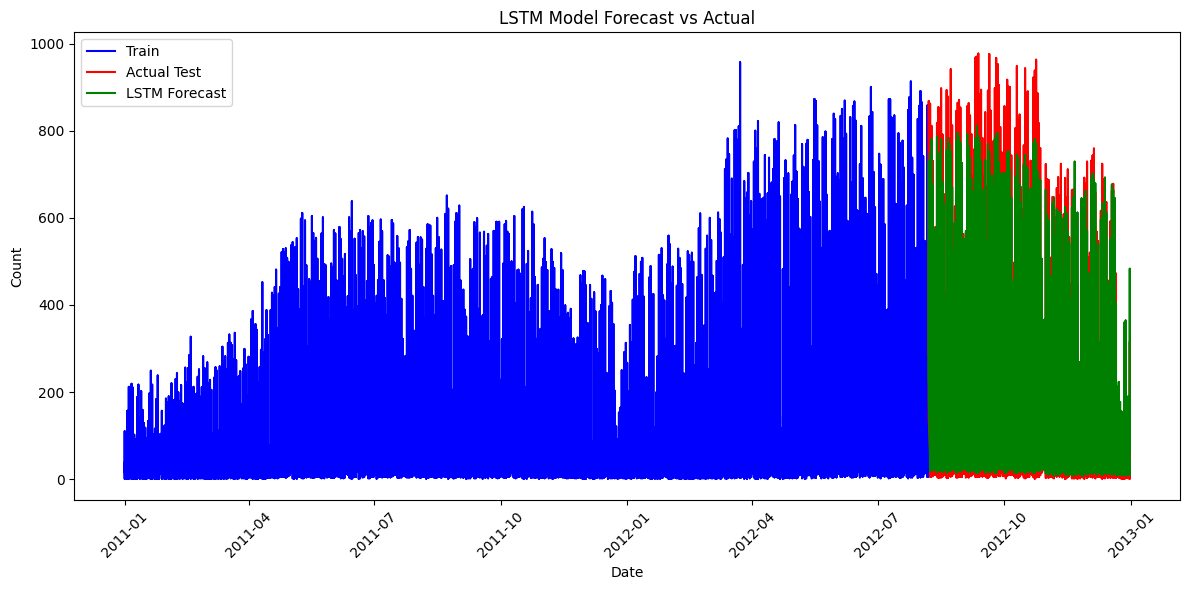

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(data['date'][:len(y_train)], y_train, label='Train', color='blue')
plt.plot(data['date'][len(y_train):], y_test, label='Actual Test', color='red')
plt.plot(data['date'][len(y_train):], predictions_lstm, label='LSTM Forecast', color='green')
plt.title('LSTM Model Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()